In [1]:
import argparse
import os
import struct
import time
from pathlib import Path
from typing import List, Optional, Callable, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# For visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
class VDBLeafDataset(Dataset):
    def __init__(
            self,
            npy_files: Sequence[str | Path],
            transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
            *,
            include_origins: bool = False,
            origins_root: str | Path | None = None,
            origins_suffix: str = "._origins.npy",
    ) -> None:
        super().__init__()

        self.transform = transform
        self.include_origins = include_origins

        # --- mmap all data files -------------------------------------------------
        self.arrays: List[np.memmap] = []
        self.origin_arrays: List[np.memmap] | None = [] if include_origins else None

        for f in npy_files:
            arr = np.load(f, mmap_mode="r")
            if arr.shape[1:] != (8, 8, 8):
                raise ValueError(f"{f}: expected (N, 8, 8, 8), got {arr.shape}")
            self.arrays.append(arr)

            if include_origins:
                if origins_root is not None:
                    origin_path = Path(origins_root) / (Path(f).stem + origins_suffix)
                else:
                    origin_path = Path(f).with_suffix(origins_suffix)
                if not origin_path.exists():
                    raise FileNotFoundError(origin_path)

                self.origin_arrays.append(np.load(origin_path, mmap_mode="r"))

        # --- pre-compute global index mapping ------------------------------------
        lengths = np.fromiter((a.shape[0] for a in self.arrays), dtype=np.int64)
        self.file_offsets = np.concatenate(([0], np.cumsum(lengths)))
        self.total_leaves: int = int(self.file_offsets[-1])

    # ---------------------------------------------------------------------------

    def __len__(self) -> int:
        return self.total_leaves

    def __getitem__(self, idx: int):
        if not (0 <= idx < self.total_leaves):
            raise IndexError(idx)

        # locate (file, local) in O(log n) inside highly-optimised C code
        file_idx = int(np.searchsorted(self.file_offsets, idx, side="right") - 1)
        local_idx = idx - int(self.file_offsets[file_idx])

        # zero-copy view from the mmap’d array
        leaf_np = self.arrays[file_idx][local_idx].astype(np.float32, copy=True)
        leaf = torch.from_numpy(leaf_np).to(torch.float32).unsqueeze(0)

        if self.transform is not None:
            leaf = self.transform(leaf)

        if self.include_origins:
            origin_np = self.origin_arrays[file_idx][local_idx].astype(np.int32, copy=False)
            origin = torch.from_numpy(origin_np)
            return leaf, origin

        return leaf


In [3]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int,
                 commitment_cost: float, decay: float = 0.99, eps: float = 1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.eps = eps

        # Initialize embeddings (small variance + normalize)
        embed = torch.randn(num_embeddings, embedding_dim)
        embed = F.normalize(embed, dim=1)
        
        self.register_buffer('embedding', embed)
        self.register_buffer('cluster_size', torch.ones(num_embeddings))
        self.register_buffer('embed_avg', embed.clone().detach())

    def forward(self, x)  -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        D = self.embedding_dim

        # Build the permutation list explicitly: [0, 2, 3, …, n, 1]
        permute_fwd: List[int] = [0] + list(range(2, x.dim())) + [1]
        
        permuted_x = torch.permute(x, permute_fwd).contiguous()
        flat = permuted_x.view(-1, D)

        # Compute distances
        distances = (
            torch.sum(flat**2, dim=1, keepdim=True)
            + torch.sum(self.embedding**2, dim=1)
            - 2 * torch.mm(flat, self.embedding.t())
        )

        # Get nearest codes
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(flat.dtype)

        # Quantize
        quantized = encodings @ self.embedding
        quantized = quantized.view(permuted_x.shape)
        
        permute_back: List[int] = [0, x.dim() - 1] + list(range(1, x.dim() - 1))
        quantized = torch.permute(quantized, permute_back)

        # EMA updates
        if self.training:
            with torch.no_grad():
                encodings_sum = encodings.sum(0)
                self.cluster_size.mul_(self.decay).add_(encodings_sum, alpha=1 - self.decay)
                
                dw = encodings.t() @ flat.detach()
                self.embed_avg.mul_(self.decay).add_(dw, alpha=1 - self.decay)
                
                n = self.cluster_size.clamp(min=self.eps)
                self.embedding.copy_(self.embed_avg / n.unsqueeze(1))

        commitment_loss = self.commitment_cost * F.mse_loss(x, quantized.detach())
        loss = commitment_loss

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        # Perplexity
        avg_probs = encodings.mean(0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity




class Encoder(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            # 8³ → 4³
            nn.Conv3d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            
            # Refine at 4³
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            # Final projection
            nn.Conv3d(64, embedding_dim, kernel_size=3, stride=1, padding=1),
        )
    def forward(self, x):
        return self.net(x)




class Decoder(nn.Module):
    def __init__(self, embedding_dim, out_channels):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            # Expand from embedding_dim
            nn.Conv3d(embedding_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            # 4³ → 8³
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            
            # Final reconstruction
            nn.Conv3d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),

        )
    def forward(self, x):
        return self.net(x)




class VQVAE(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, embedding_dim)
        self.quantizer = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost=0.25)
        self.decoder = Decoder(embedding_dim, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, perplexity = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, perplexity

    def encode(self, x) -> torch.Tensor:
        z = self.encoder(x)
        
        shape = list(z.shape)         # List[int]
        B, D = shape[0], shape[1]
        spatial = shape[2:]

        permute_fwd = [0] + list(range(2, z.dim())) + [1]
        flat_z = (torch.permute(z, permute_fwd)
                  .contiguous()
                  .view(-1, D)
                  )
    
        distances = (torch.sum(flat_z**2, dim=1, keepdim=True) 
                     + torch.sum(self.quantizer.embedding**2, dim=1)
                     - 2 * torch.matmul(flat_z, self.quantizer.embedding.t()))
        indices = torch.argmin(distances, dim=1)
        
        return indices.view(B, *spatial)

    @torch.jit.export
    def decode(self, indices):
        quantized_vectors = F.embedding(indices, self.quantizer.embedding)
        permute_back = [0, quantized_vectors.dim() - 1] + list(range(1, quantized_vectors.dim() - 1))
        quantized_for_decoder = torch.permute(quantized_vectors, permute_back)
        x_recon = self.decoder(quantized_for_decoder)
        return x_recon
    
    def get_codebook(self) -> torch.Tensor:
        return self.quantizer.embedding

In [4]:
# Hyperparameters
BATCH_SIZE = 8192*2
EPOCHS = 15
LR = 5e-4
IN_CHANNELS = 1
EMBEDDING_DIM = 128 # The dimensionality of the embeddings
NUM_EMBEDDINGS = 256 # The size of the codebook (the "dictionary")
COMMITMENT_COST = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

npy_files = list(Path("data/npy").glob("*.npy"))
if not npy_files:
    raise ValueError(f"No .npy files found in /data/npy")

print(f"Found {len(npy_files)} .npy files")

vdb_dataset = VDBLeafDataset(npy_files=npy_files, include_origins=False)
print(f"Dataset created with {len(vdb_dataset)} total blocks.")

# keep 10% of the dataset for validation
split_idx = int(len(vdb_dataset) * 0.5)
vdb_dataset_train = torch.utils.data.Subset(vdb_dataset, range(split_idx))
vdb_dataset_val = torch.utils.data.Subset(vdb_dataset, range(split_idx, len(vdb_dataset)))
print(f"Training dataset size: {len(vdb_dataset_train)}")
print(f"Validation dataset size: {len(vdb_dataset_val)}")


train_loader = DataLoader(
    vdb_dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    vdb_dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True,
)


Using device: cuda
Found 120 .npy files
Dataset created with 721739 total blocks.
Training dataset size: 360869
Validation dataset size: 360870


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VQVAE(IN_CHANNELS, EMBEDDING_DIM, NUM_EMBEDDINGS, COMMITMENT_COST).to(device)
optimizer = Adam(model.parameters(), lr=LR)

Using device: cuda


In [ ]:

print("Starting training with data from DataLoader...")

optimizer = Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    total_recon_loss = 0.0
    total_vq_loss = 0

    for leaves in tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        leaves = leaves.to(device, non_blocking=True)

        optimizer.zero_grad()
        x_recon, vq_loss, perplexity = model(leaves)
        recon_error = F.mse_loss(x_recon, leaves)
        loss = recon_error + vq_loss

        loss.backward()
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_recon_loss += recon_error.item()
        total_vq_loss += vq_loss.item()

        # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for leaves in val_loader:
            leaves = leaves.to(device)
            x_recon, vq_loss, _ = model(leaves)
            recon_error = F.mse_loss(x_recon, leaves)
            val_loss += recon_error.item() + vq_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

print("Training finished.")

Visualizing Reconstruction Quality for a Single Example


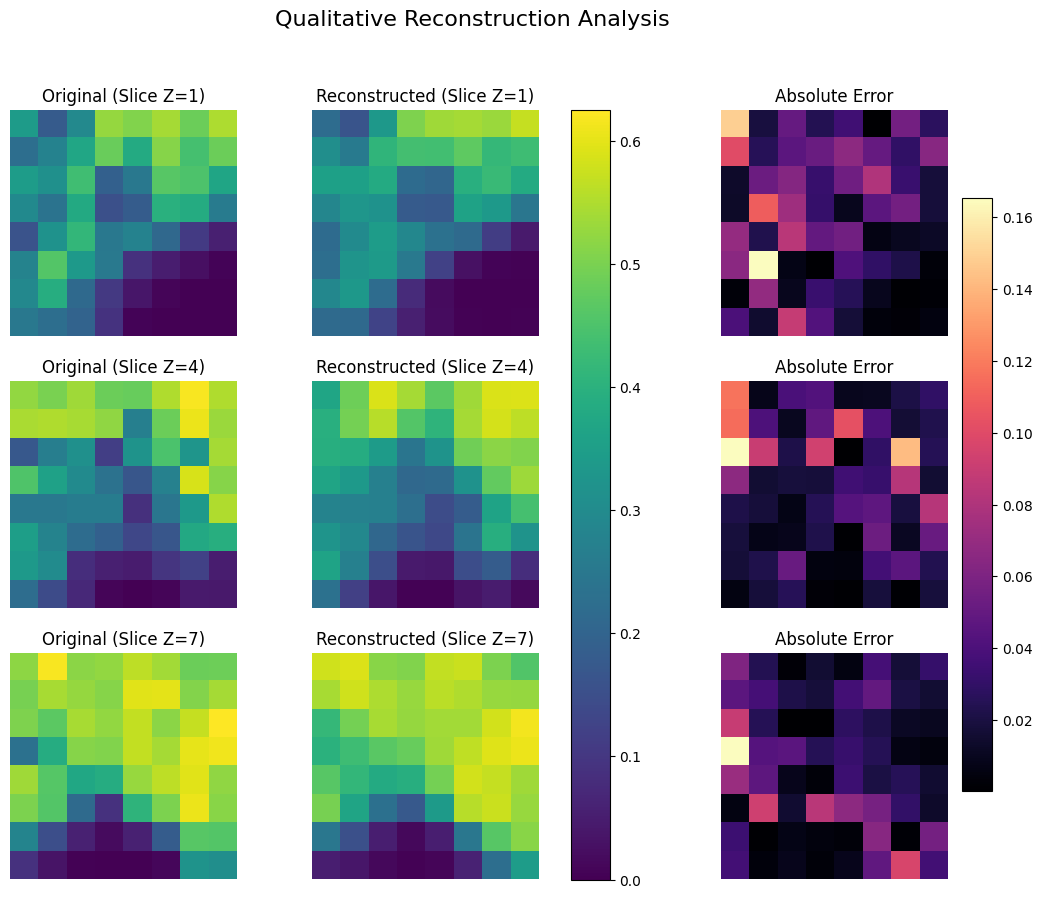

In [6]:
print("Visualizing Reconstruction Quality for a Single Example")
model.eval()

# Save the model state_dict
model_path = "C:/Users/zphrfx/Desktop/hdk/VQVDB/models/vqvae.pth"

# Visualize the reconstruction quality for a single example
model.load_state_dict(torch.load(model_path, map_location=device))


# Get a random block from the dataset
original_block = vdb_dataset[7312].unsqueeze(0).to(device)

# Perform the full compression/decompression cycle
indices = model.encode(original_block)
reconstructed_block = model.decode(indices)

# Detach from GPU and convert to numpy for plotting
original_np = original_block.squeeze().cpu().numpy()
reconstructed_np = reconstructed_block.squeeze().detach().cpu().numpy()
error_np = np.abs(original_np - reconstructed_np)

# Get consistent color limits for fair comparison
vmin = min(original_np.min(), reconstructed_np.min())
vmax = max(original_np.max(), reconstructed_np.max())

# --- Plot 1: Slice-by-Slice Comparison ---
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
slices_to_show = [1, 4, 7] # Show slices from the Z-axis of the 8x8x8 cube

for i, slice_idx in enumerate(slices_to_show):
    # Original
    im1 = axes[i, 0].imshow(original_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 0].set_title(f'Original (Slice Z={slice_idx})')
    axes[i, 0].axis('off')

    # Reconstructed
    im2 = axes[i, 1].imshow(reconstructed_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 1].set_title(f'Reconstructed (Slice Z={slice_idx})')
    axes[i, 1].axis('off')
    
    # Error Map
    im3 = axes[i, 2].imshow(error_np[slice_idx, :, :], cmap='magma')
    axes[i, 2].set_title('Absolute Error')
    axes[i, 2].axis('off')

fig.colorbar(im1, ax=axes[:,:2], orientation='vertical', fraction=.1)
fig.colorbar(im3, ax=axes[:,2], orientation='vertical', fraction=.1)
plt.suptitle('Qualitative Reconstruction Analysis', fontsize=16)
plt.show()

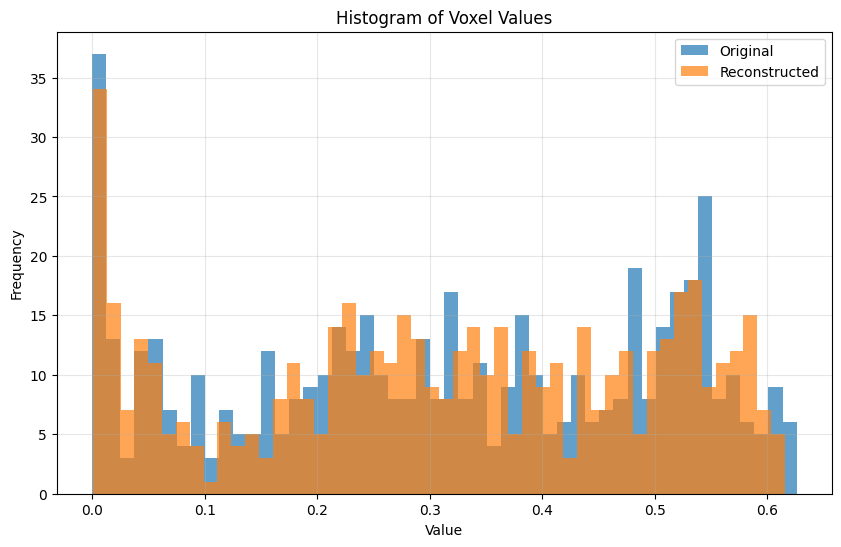

KL Divergence between original and reconstructed blocks: 0.0174


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(original_np.flatten(), bins=50, alpha=0.7, label='Original')
plt.hist(reconstructed_np.flatten(), bins=50, alpha=0.7, label='Reconstructed')
plt.title('Histogram of Voxel Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

from scipy.stats import entropy
def kl_divergence(p, q):
    """Compute KL divergence between two distributions."""
    p = p.flatten()
    q = q.flatten()
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    return entropy(p, q)
kl_div = kl_divergence(original_np, reconstructed_np)
print(f"KL Divergence between original and reconstructed blocks: {kl_div:.4f}")

PCA of the learned codebook vectors:


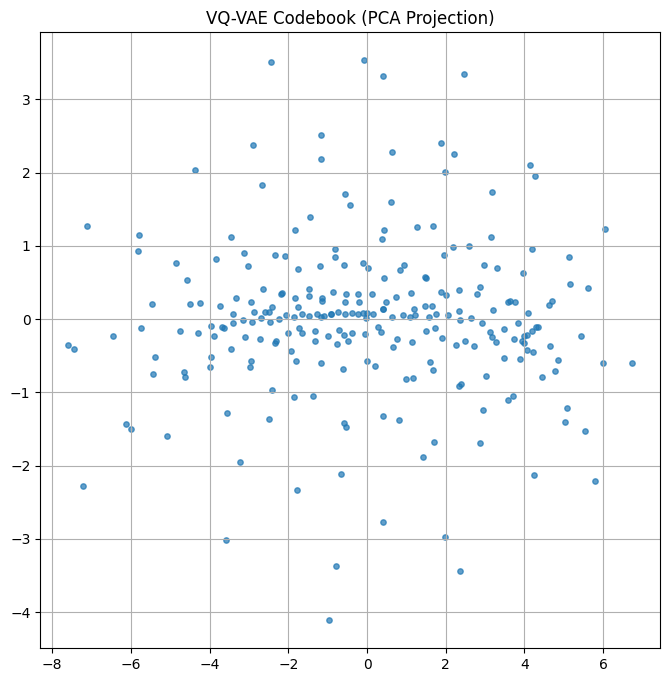


Calculating codebook usage across the entire dataset...


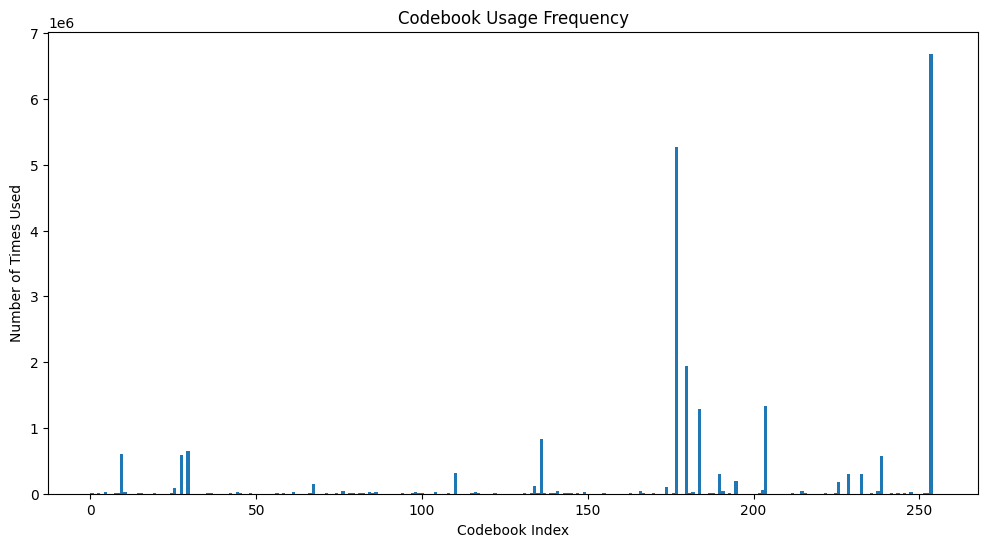

Number of 'dead' (unused) codes: 0 out of 256


In [8]:
print("PCA of the learned codebook vectors:")
codebook = model.quantizer.embedding.data.cpu()
pca = PCA(n_components=2)
codebook_2d = pca.fit_transform(codebook)
plt.figure(figsize=(8, 8))
plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], s=15, alpha=0.7)
plt.title('VQ-VAE Codebook (PCA Projection)')
plt.grid(True)
plt.show()

# --- Plot 2: Codebook Usage Histogram ---
# This is a powerful diagnostic. It requires running the encoder on the whole dataset.
print("\nCalculating codebook usage across the entire dataset...")
model.eval()
all_indices = []
# Create a dataloader without shuffling to iterate through the dataset
full_loader = DataLoader(vdb_dataset_val, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for data_batch in full_loader:
        data_batch = data_batch.to(device) # Move data to the same device as the model
        indices = model.encode(data_batch)
        all_indices.append(indices.cpu().numpy().flatten())

all_indices = np.concatenate(all_indices)

plt.figure(figsize=(12, 6))
plt.hist(all_indices, bins=NUM_EMBEDDINGS, range=(0, NUM_EMBEDDINGS-1))
plt.title('Codebook Usage Frequency')
plt.xlabel('Codebook Index')
plt.ylabel('Number of Times Used')
plt.show()

num_dead_codes = NUM_EMBEDDINGS - len(np.unique(all_indices))
print(f"Number of 'dead' (unused) codes: {num_dead_codes} out of {NUM_EMBEDDINGS}")

In [9]:
# --- Codebook Perplexity + Active-Code Ratio ---
counts = np.bincount(all_indices, minlength=NUM_EMBEDDINGS).astype(np.float64)
probs = counts / counts.sum()
nonzero = probs > 0
perplexity = np.exp(-(probs[nonzero] * np.log(probs[nonzero])).sum())
active_ratio = nonzero.mean()

print(f"Codebook perplexity: {perplexity:.2f}")
print(f"Active-code ratio  : {active_ratio*100:.1f}%")


Codebook perplexity: 12.90
Active-code ratio  : 100.0%


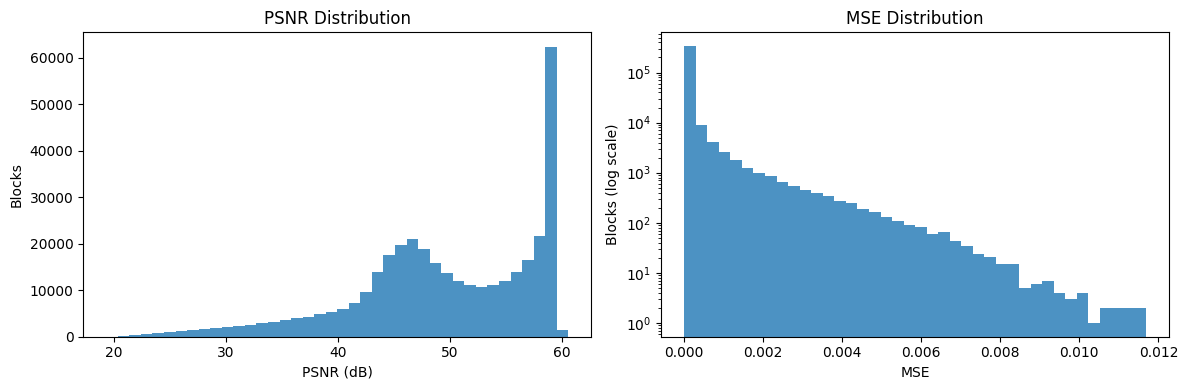

In [10]:
from math import log10

def psnr(x, y, vmax=1.0):
    mse = torch.mean((x - y) ** 2).item()
    return 20 * log10(vmax) - 10 * log10(mse + 1e-12)

model.eval()
psnr_list, mse_list = [], []

with torch.no_grad():
    for batch in DataLoader(vdb_dataset_val, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        rec = model.decode(model.encode(batch))
        mse = ((batch - rec) ** 2).view(len(batch), -1).mean(dim=1)
        mse_list.extend(mse.cpu().numpy())
        psnr_list.extend([psnr(b, r) for b, r in zip(batch, rec)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(psnr_list, bins=40, alpha=.8)
plt.title('PSNR Distribution'); plt.xlabel('PSNR (dB)'); plt.ylabel('Blocks')

plt.subplot(1,2,2)
plt.hist(mse_list, bins=40, alpha=.8, log=True)  # log-y to see the tail
plt.title('MSE Distribution'); plt.xlabel('MSE'); plt.ylabel('Blocks (log scale)')
plt.tight_layout(); plt.show()


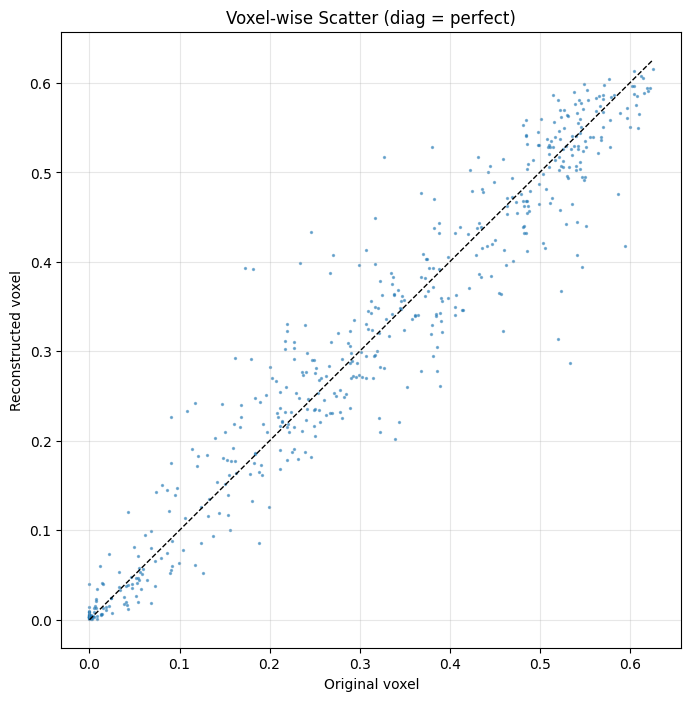

In [11]:
n_points = 100_000
orig_sample = original_np.flatten()
recon_sample = reconstructed_np.flatten()
if len(orig_sample) > n_points:
    idx = np.random.choice(len(orig_sample), n_points, replace=False)
    orig_sample = orig_sample[idx]; recon_sample = recon_sample[idx]

plt.figure(figsize=(8,8))
plt.scatter(orig_sample, recon_sample, s=2, alpha=.5)
lims = [min(orig_sample.min(), recon_sample.min()),
        max(orig_sample.max(), recon_sample.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Original voxel'); plt.ylabel('Reconstructed voxel')
plt.title('Voxel-wise Scatter (diag = perfect)')
plt.grid(True, alpha=.3); plt.show()


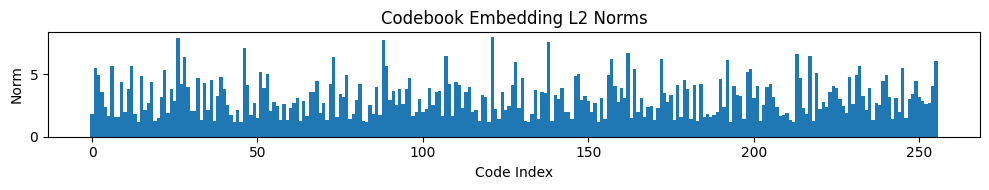

In [12]:
# --- L2 norm of each embedding vector ---
embed_norm = torch.linalg.norm(model.quantizer.embedding.data, dim=1).cpu().numpy()
plt.figure(figsize=(10,2))
plt.bar(range(NUM_EMBEDDINGS), embed_norm, width=1.0)
plt.title('Codebook Embedding L2 Norms'); plt.xlabel('Code Index'); plt.ylabel('Norm')
plt.tight_layout(); plt.show()


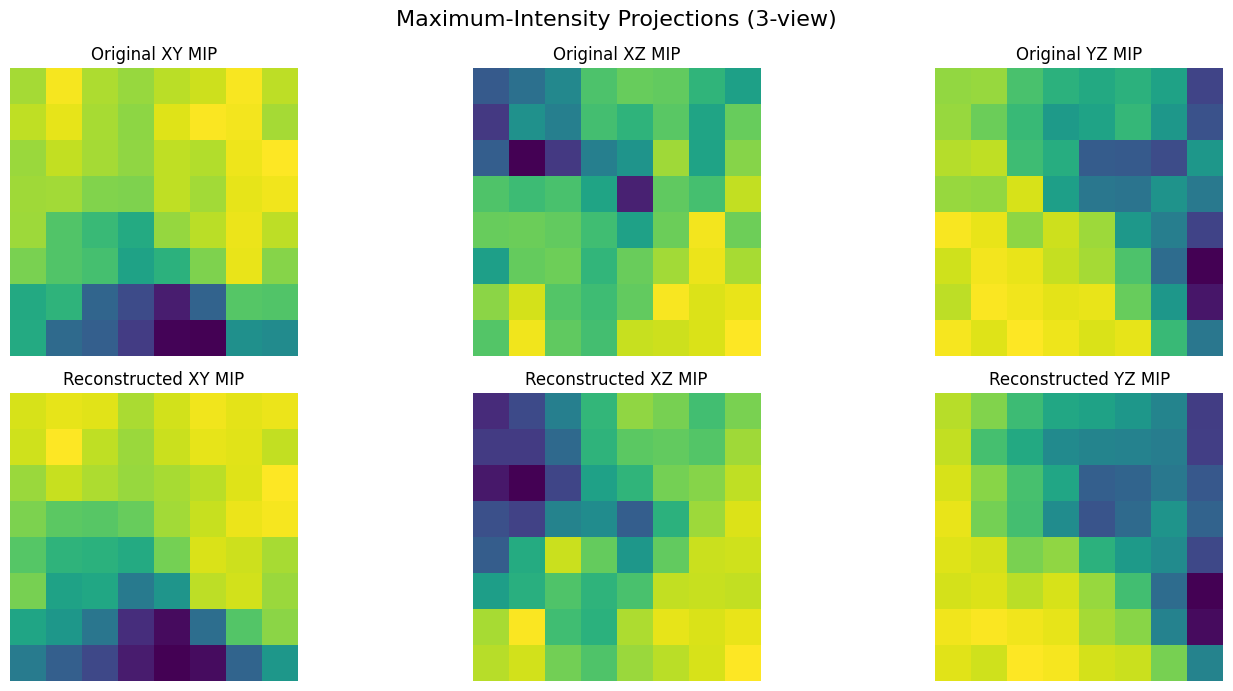

In [13]:
def mip(vol, axis):
    """Maximum-intensity projection along a single axis."""
    return vol.max(axis=axis)

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
views = [(0, 'XY MIP'),   # collapse Z
         (1, 'XZ MIP'),   # collapse Y
         (2, 'YZ MIP')]   # collapse X

for col, (axis_to_collapse, title) in enumerate(views):
    axes[0, col].imshow(mip(original_np, axis=axis_to_collapse), cmap='viridis')
    axes[0, col].set_title(f'Original {title}')
    axes[0, col].axis('off')

    axes[1, col].imshow(mip(reconstructed_np, axis=axis_to_collapse), cmap='viridis')
    axes[1, col].set_title(f'Reconstructed {title}')
    axes[1, col].axis('off')

plt.suptitle('Maximum-Intensity Projections (3-view)', fontsize=16)
plt.tight_layout()
plt.show()

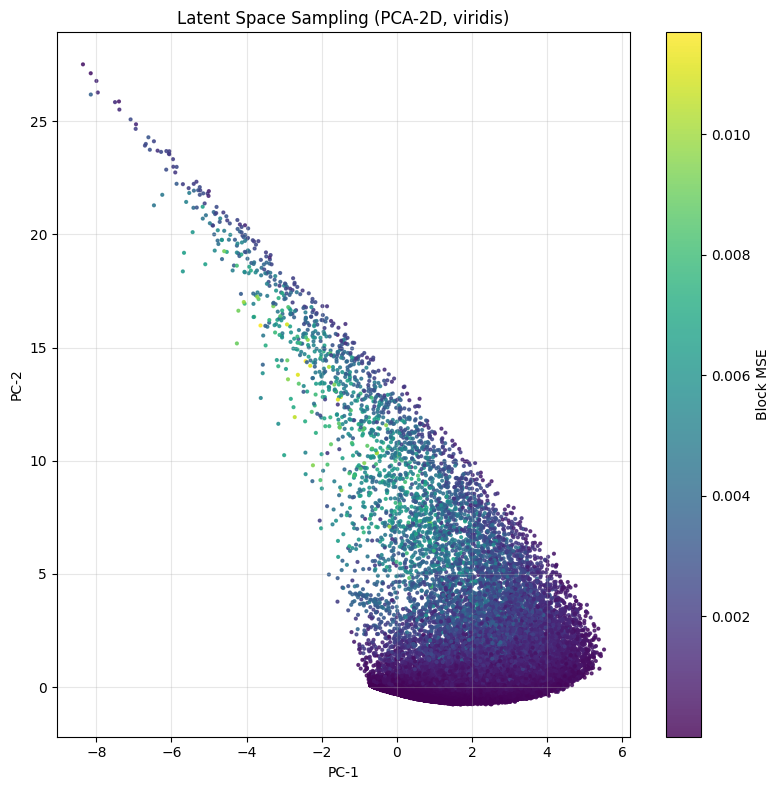

In [14]:
# ---------- 1. Build a per-block latent vector ----------
model.eval()
latents, errs = [], []          # errs = optional colouring

with torch.no_grad():
    for batch in DataLoader(vdb_dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False):
        batch = batch.to(device)
        
        idx = model.encode(batch).long()               # (B, Z, Y, X) indices
        emb = model.quantizer.embedding[idx.view(-1)]  # (B*Z*Y*X, C)
        emb = emb.view(*idx.shape, -1)                 # (B, Z, Y, X, C)
        mean_emb = emb.mean(dim=(1, 2, 3))             # (B, C)
        latents.append(mean_emb.cpu())
        
        # Optional: per-block MSE for coloured scatter
        rec = model.decode(idx)
        errs.append(((batch - rec) ** 2)
                    .view(len(batch), -1)
                    .mean(dim=1)
                    .cpu())

latents = torch.cat(latents, dim=0).numpy()   # (N, C)
errs    = torch.cat(errs, dim=0).numpy()      # (N,)

# ---------- 2. PCA to 2-D ----------
from sklearn.decomposition import FastICA
pca2 = FastICA(n_components=2, random_state=0)
latents_2d = pca2.fit_transform(latents)      # (N, 2)

# ---------- 3. Scatter with viridis ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sc = plt.scatter(latents_2d[:, 0],
                 latents_2d[:, 1],
                 c=errs,                 # <- set to None for uniform colour
                 cmap='viridis',
                 s=4,
                 alpha=0.8)
if sc.get_array() is not None:           # only if colouring by a value
    plt.colorbar(sc, label='Block MSE')

plt.title('Latent Space Sampling (PCA-2D, viridis)')
plt.xlabel('PC-1'); plt.ylabel('PC-2')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()
